In [4]:
# General imports
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import math
import random
import sys, gc, time
import os

# data
import datetime
import itertools
import json
import pickle

# sklearn
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler #StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

# keras
# from keras_models import create_model17EN1EN2emb1, create_model17noEN1EN2, create_model17

# model
import lightgbm as lgb
from bayes_opt import BayesianOptimization

# custom modules
# from engine.features_yj import Features
from preprocess import load_df_added, drop_useless, check_na, run_label_all, remove_outliers, run_stdscale


In [5]:
#local_DIR = os.getcwd()
featured_DATA_DIR = '../data/20'
# PROCESSED_DATA_DIR = local_DIR +'/data/21'

df_wd_lag = pd.read_pickle(featured_DATA_DIR + '/train_fin_wk_lag.pkl')
df_wd_no_lag = pd.read_pickle(featured_DATA_DIR + '/train_fin_wk_no_lag.pkl')
df_wk_lag = pd.read_pickle(featured_DATA_DIR + '/train_fin_wd_lag.pkl')
df_wk_no_lag = pd.read_pickle(featured_DATA_DIR + '/train_fin_wd_no_lag.pkl')
#df_all_lag = pd.read_pickle(featured_DATA_DIR + '/train_fin_light_ver.pkl')
#df_all = pd.read_pickle(featured_DATA_DIR + '/train_fin_wk_lag.pkl')


## drop unnecessary lag columns
df_wd_lag = df_wd_lag.drop(columns = ['lag_sales_wk_1','lag_sales_wk_2'])
df_wk_lag = df_wk_lag.drop(columns = ['lag_sales_wd_1', 'lag_sales_wd_2','lag_sales_wd_3', 'lag_sales_wd_4', 'lag_sales_wd_5'])


In [6]:
lag_col1 = ['lag_scode_count','lag_mcode_price','lag_mcode_count','lag_bigcat_price','lag_bigcat_count',
            'lag_bigcat_price_day','lag_bigcat_count_day','lag_small_c_price','lag_small_c_count']

lag_col2 = ['rolling_mean_7', 'rolling_mean_14', 'lag_sales_wd_1', 'lag_sales_wd_2','lag_sales_wd_3',
            'lag_sales_wd_4', 'lag_sales_wd_5', 'lag_sales_wk_1','lag_sales_wk_2', 'ts_pred']

cat_col = ['상품군','weekdays','show_id','small_c','middle_c','big_c',
                        'pay','months','hours_inweek','weekends','japp','parttime',
                        'min_start','primetime','prime_origin','prime_smallc',
                        'freq','bpower','steady','men','pay','luxury',
                        'spring','summer','fall','winter','rain']

In [7]:
## simple function that will be used for run_preprocess
def na_to_zeroes(df):
    """
    :objective: Change all na's to zero.(just for original lag!)
    :return: pandas dataframe
    """
    xcol = [x for x in df.columns if x in lag_col1+lag_col2]
    for col in xcol:
        df[col] = df[col].fillna(0)

    return df

def drop_cat(df_pca):
    """
    :objective: Before PCA, drop categorical variables
    :return: pandas dataframe
    """
    xcol = [x for x in df_pca.columns if x in cat_col+lag_col2]
    df_pca = df_pca.drop(columns = xcol)
    df_pca = df_pca.drop(columns = '취급액')

    return df_pca

def run_pca(df_pca_scaled, n_components = 5):
    """
    :objective: Run PCA with n_components = 5
    :return: pandas dataframe
    """
    pca = PCA(n_components = 5)
    pca.fit(df_pca_scaled)
    df_pca = pca.transform(df_pca_scaled)

    return df_pca

## run preprocessing in a shot
## pca is optional and only applied to numeric features other than 'lag'
## NOTICE: removing outliers were run prior to dividing train/val
## if replace = True, new PCA will replace corresponding numerical columns
## if you want to simply add PCA columns to original data, set replace = False
def run_preprocess(df, pca = True, replace = True):
    """
    :objective: Run Feature deletion, NA imputation, label encoding, pca(optional)
    :return: pandas dataframe
    """
    df = drop_useless(df)
    df = na_to_zeroes(df)
    df = remove_outliers(df)
    df = run_label_all(df)
    df1 = df.copy()
    if pca:
        xcol = [x for x in df1.columns if x in cat_col+lag_col2]
        df_pca = df1.copy()
        df_pca = drop_cat(df_pca).copy()
        df_pca = run_stdscale(df_pca)
        df_pca = run_pca(df_pca)
        if replace:
            df_pca1 = pd.concat([df1[xcol], pd.DataFrame(df_pca)], axis=1)
            return df_pca1
        else:
            df_pca2 = pd.concat([df1, pd.DataFrame(df_pca)], axis=1)
            return df_pca2
    else:
        return df1


In [8]:
from lightgbm import LGBMRegressor

In [9]:
df_wd_lag_PP = run_preprocess(df_wd_lag, pca = True, replace = False)
df_wd_no_lag_PP = run_preprocess(df_wd_no_lag, pca = True, replace =False)

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data Types

## 1. All + PCA

In [11]:
train1_x = df_wd_lag_PP.iloc[:16904,:].drop(columns = ['index','show_id','취급액'])
train1_y = df_wd_lag_PP.iloc[:16904,3]
val1_x = df_wd_lag_PP.iloc[16904:,:].drop(columns = ['index','show_id','취급액'])
val1_y = df_wd_lag_PP.iloc[16904:,3]

## 2. All

In [12]:
train2_x = df_wd_lag_PP.iloc[:16904,:].drop(columns = ['index','show_id','취급액',0,1,2,3,4])
train2_y = df_wd_lag_PP.iloc[:16904,3]
val2_x = df_wd_lag_PP.iloc[16904:,:].drop(columns = ['index','show_id','취급액',0,1,2,3,4])
val2_y = df_wd_lag_PP.iloc[16904:,3]

## 3. Just Lags

In [13]:
xcol = [x for x in df_wd_lag_PP.columns if x in lag_col1+lag_col2]
train3_x = df_wd_lag_PP[xcol+['판매단가','상품군']].iloc[:16904,:]
train3_y = df_wd_lag_PP.iloc[:16904,3]
val3_x = df_wd_lag_PP[xcol+['판매단가','상품군']].iloc[16904:,:]
val3_y = df_wd_lag_PP.iloc[16904:,3]

## 4. Without Lags / No PCA

In [21]:
train4_x = df_wd_no_lag_PP.drop(columns = ['index','show_id','취급액']).iloc[:16904,:]
train4_y = df_wd_no_lag_PP.iloc[:16904,3]
val4_x = df_wd_no_lag_PP.drop(columns = ['index','show_id','취급액']).iloc[16904:,:]
val4_y = df_wd_no_lag_PP.iloc[16904:,3]

## 5. Without (some) categorical variables

In [15]:
xcol = ['index','weekdays','show_id','small_c','middle_c','big_c',
                        'months','weekends','parttime',
                        'min_start','primetime','prime_smallc',
                        'freq','bpower','steady','men','pay','luxury',
                        'spring','summer','fall','winter'] #rain japp hiw 상품군
train5_x = df_wd_lag_PP.iloc[:16904,:].drop(columns = xcol+['취급액'])
train5_y = df_wd_lag_PP.iloc[:16904,3]
val5_x = df_wd_lag_PP.iloc[16904:,:].drop(columns = xcol+['취급액'])
val5_y = df_wd_lag_PP.iloc[16904:,3]

## 6. All + replace PCA

In [45]:
df_wd_lag_PP_f = run_preprocess(df_wd_lag, pca = True, replace = True)

In [47]:
df_wd_lag_PP_f.columns

Index([            '상품군',          'months',        'weekdays',
          'hours_inweek',        'weekends',       'min_start',
                  'japp',        'parttime',         'show_id',
               'small_c',        'middle_c',           'big_c',
             'primetime',    'prime_smallc',            'freq',
                'bpower',          'steady',             'men',
                'luxury',             'pay',          'spring',
                'summer',            'fall',          'winter',
                  'rain',  'rolling_mean_7', 'rolling_mean_14',
        'lag_sales_wd_1',  'lag_sales_wd_2',  'lag_sales_wd_3',
        'lag_sales_wd_4',  'lag_sales_wd_5',         'ts_pred',
                       0,                 1,                 2,
                       3,                 4],
      dtype='object')

In [48]:
train6_x = df_wd_lag_PP_f.iloc[:16904,:].drop(columns = ['show_id'])
train6_y = df_wd_lag_PP.iloc[:16904,3]
val6_x = df_wd_lag_PP_f.iloc[16904:,:].drop(columns = ['show_id'])
val6_y = df_wd_lag_PP.iloc[16904:,3]

## All + exclude small_c

In [75]:
train7_x = df_wd_lag_PP.iloc[:16904,:].drop(columns = ['index','show_id','취급액','small_c',0,1,2,3,4])
train7_y = df_wd_lag_PP.iloc[:16904,3]
val7_x = df_wd_lag_PP.iloc[16904:,:].drop(columns = ['index','show_id','취급액','small_c',0,1,2,3,4])
val7_y = df_wd_lag_PP.iloc[16904:,3]

# Random Forest

## 5. Without categorical variables

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [32]:
rf = RandomForestRegressor(n_estimators = 1000, n_jobs = -1,oob_score = True,bootstrap = True,random_state = 42)
rf.fit(train5_x,train5_y)

#print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
      

RandomForestRegressor(n_estimators=1000, n_jobs=-1, oob_score=True,
                      random_state=42)

In [33]:
y_pred_rf = rf.predict(val5_x)
def neg_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    result = (-1)*mape
    return result
neg_mape(val5_y, y_pred_rf)

-178.87412018992538

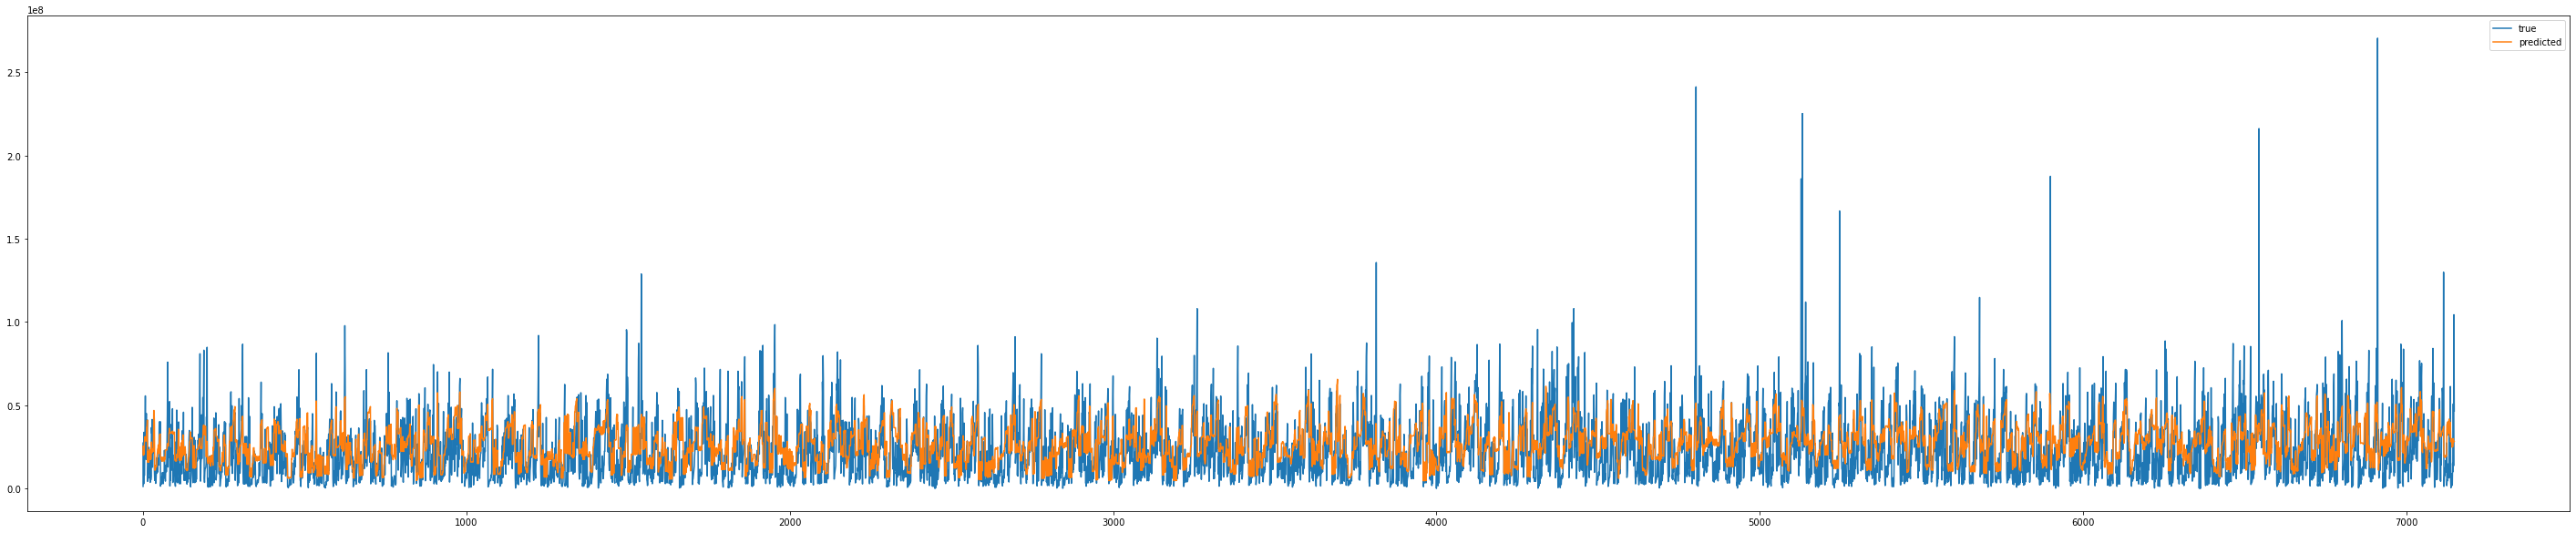

In [34]:
x = range(0,7149)
plt.figure(figsize=(50,10))
plt.plot(x,val5_y,label='true')
plt.plot(x,y_pred_rf, label='predicted')

# call with no parameters
plt.legend()

plt.show()

# Light GBM

## 1.

In [36]:
gbm1 = LGBMRegressor(objective = 'regression', 
                     boosting_type = 'dart', 
                     metric = 'mape',
                     n_estimators = 3000, #10000
                     num_leaves = 10, #10
                     learning_rate = 0.002, #0.01
                     bagging_fraction = 0.9,
                     feature_fraction = 0.5,
                     bagging_seed = 0,
                     categorical_feature = [0,9,10,11],
                     #max_depth = 10,
                                         )

#model_rmse = gbm.fit(train_x,train_y, eval_set=[(val_x, val_y)],verbose = 100, eval_metric = 'rmse', early_stopping_rounds = 100) ##100
model_mape = gbm1.fit(train1_x,train1_y, eval_set=[(val1_x, val1_y)],verbose = 100, 
                        eval_metric = 'mape', early_stopping_rounds = 100) ##100
oof_preds1 = gbm1.predict(val1_x, num_iteration= model_mape.best_iteration_)
    
oof_preds1[oof_preds1 < 0] = 0

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[100]	valid_0's mape: 1.04
[200]	valid_0's mape: 0.806968
[300]	valid_0's mape: 0.777274
[400]	valid_0's mape: 0.764176
[500]	valid_0's mape: 0.756198
[600]	valid_0's mape: 0.757485
[700]	valid_0's mape: 0.751439
[800]	valid_0's mape: 0.750618
[900]	valid_0's mape: 0.757141
[1000]	valid_0's mape: 0.762523
[1100]	valid_0's mape: 0.762
[1200]	valid_0's mape: 0.76157
[1300]	valid_0's mape: 0.775221
[1400]	valid_0's mape: 0.786054
[1500]	valid_0's mape: 0.793977
[1600]	valid_0's mape: 0.809267
[1700]	valid_0's mape: 0.809182
[1800]	valid_0's mape: 0.812401
[1900]	valid_0's mape: 0.826042
[2000]	valid_0's mape: 0.830239
[2100]	valid_0's mape: 0.844905
[2200]	valid_0's mape: 0.853576
[2300]	valid_0's mape: 0.859515
[2400]	valid_0's mape: 0.873203
[2500]	v

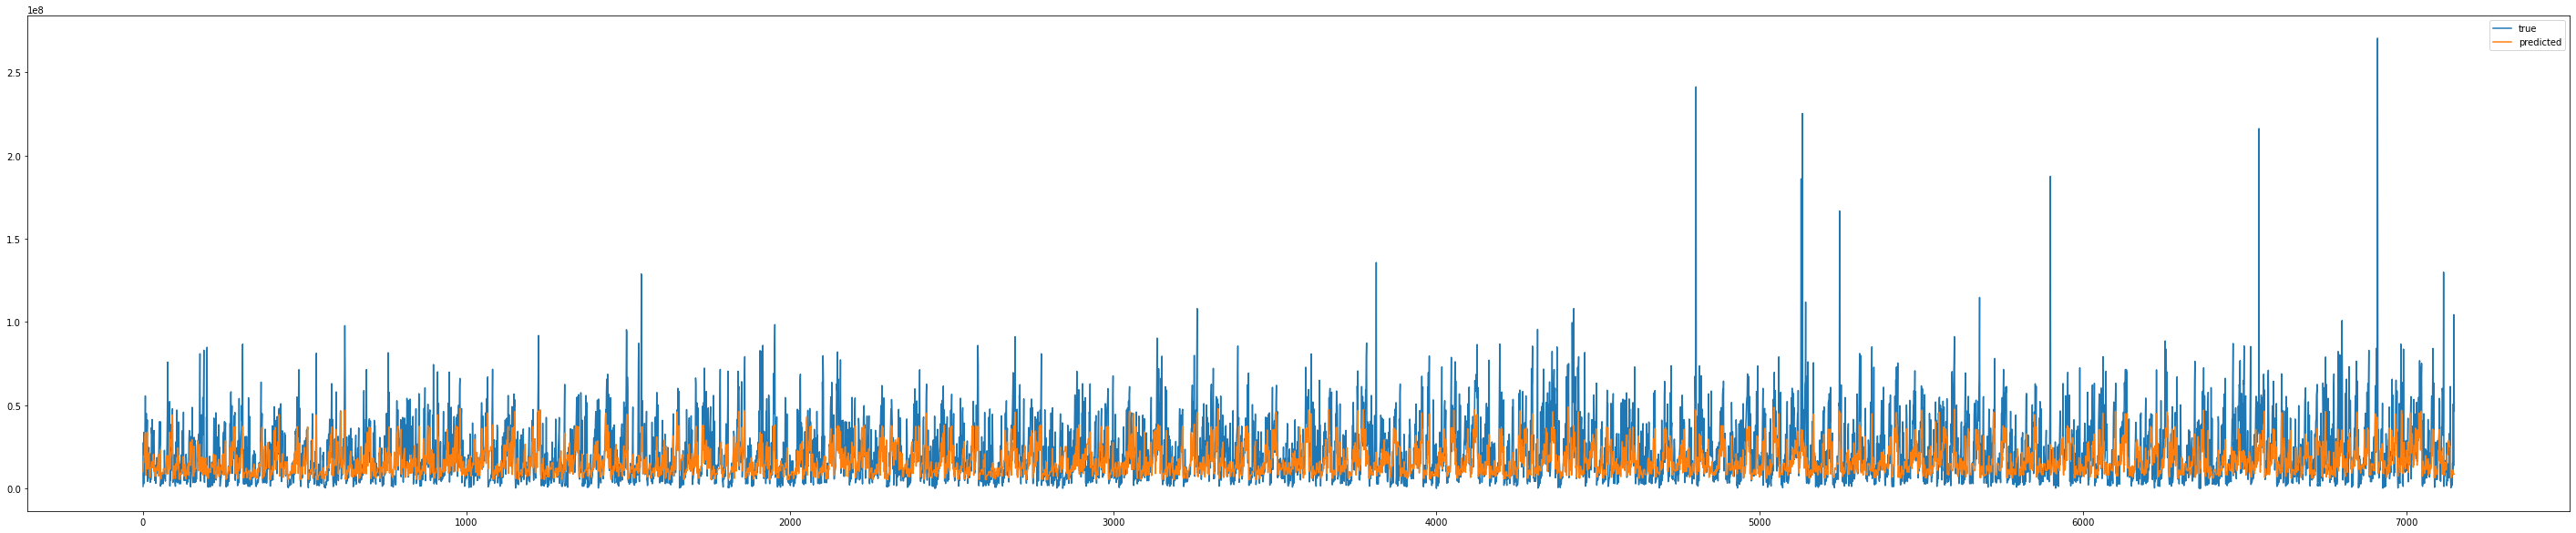

In [38]:
x = range(0,7149)
plt.figure(figsize=(50,10))
plt.plot(x,val1_y,label='true')
plt.plot(x,oof_preds1, label='predicted')

# call with no parameters
plt.legend()

plt.show()

In [40]:
neg_mape(val1_y, oof_preds1)

-88.90720370230994

## 2.

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[100]	valid_0's mape: 1.03635
[200]	valid_0's mape: 0.80385
[300]	valid_0's mape: 0.773674
[400]	valid_0's mape: 0.762631
[500]	valid_0's mape: 0.753127
[600]	valid_0's mape: 0.755555
[700]	valid_0's mape: 0.750082
[800]	valid_0's mape: 0.748406
[900]	valid_0's mape: 0.753802
[1000]	valid_0's mape: 0.757715
[1100]	valid_0's mape: 0.758652
[1200]	valid_0's mape: 0.757873
[1300]	valid_0's mape: 0.770096
[1400]	valid_0's mape: 0.782048
[1500]	valid_0's mape: 0.790092
[1600]	valid_0's mape: 0.803858
[1700]	valid_0's mape: 0.803337
[1800]	valid_0's mape: 0.805775
[1900]	valid_0's mape: 0.819837
[2000]	valid_0's mape: 0.824146
[2100]	valid_0's mape: 0.839383
[2200]	valid_0's mape: 0.848526
[2300]	valid_0's mape: 0.855869
[2400]	valid_0's mape: 0.871498
[2

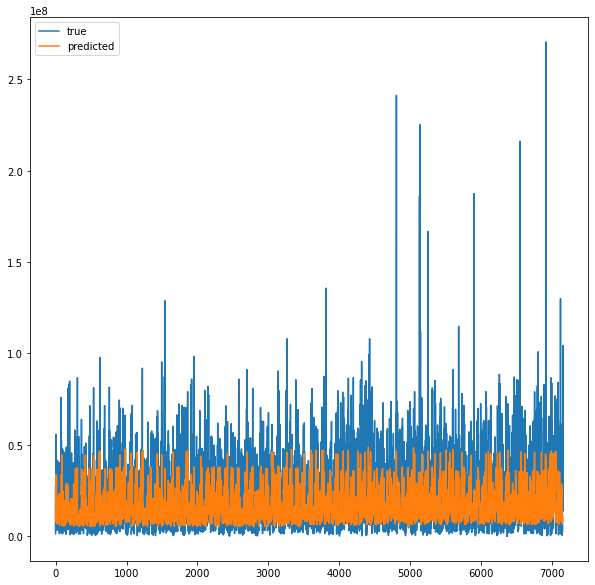

In [51]:
gbm1 = LGBMRegressor(objective = 'regression', 
                     boosting_type = 'dart', 
                     metric = 'mape',
                     n_estimators = 3000, #10000
                     num_leaves = 10, #10
                     learning_rate = 0.002, #0.01
                     bagging_fraction = 0.9,
                     feature_fraction = 0.5,
                     bagging_seed = 0,
                     categorical_feature = [0,9,10,11],
                     #max_depth = 10,
                                         )

model_mape = gbm1.fit(train2_x,train2_y, eval_set=[(val2_x, val2_y)],verbose = 100, 
                        eval_metric = 'mape', early_stopping_rounds = 100) ##100
oof_preds2 = gbm1.predict(val2_x, num_iteration= model_mape.best_iteration_)
    
oof_preds2[oof_preds2 < 0] = 0
x = range(0,7149)
plt.figure(figsize=(10,10))
plt.plot(x,val2_y,label='true')
plt.plot(x,oof_preds2, label='predicted')

# call with no parameters
plt.legend()

plt.show()

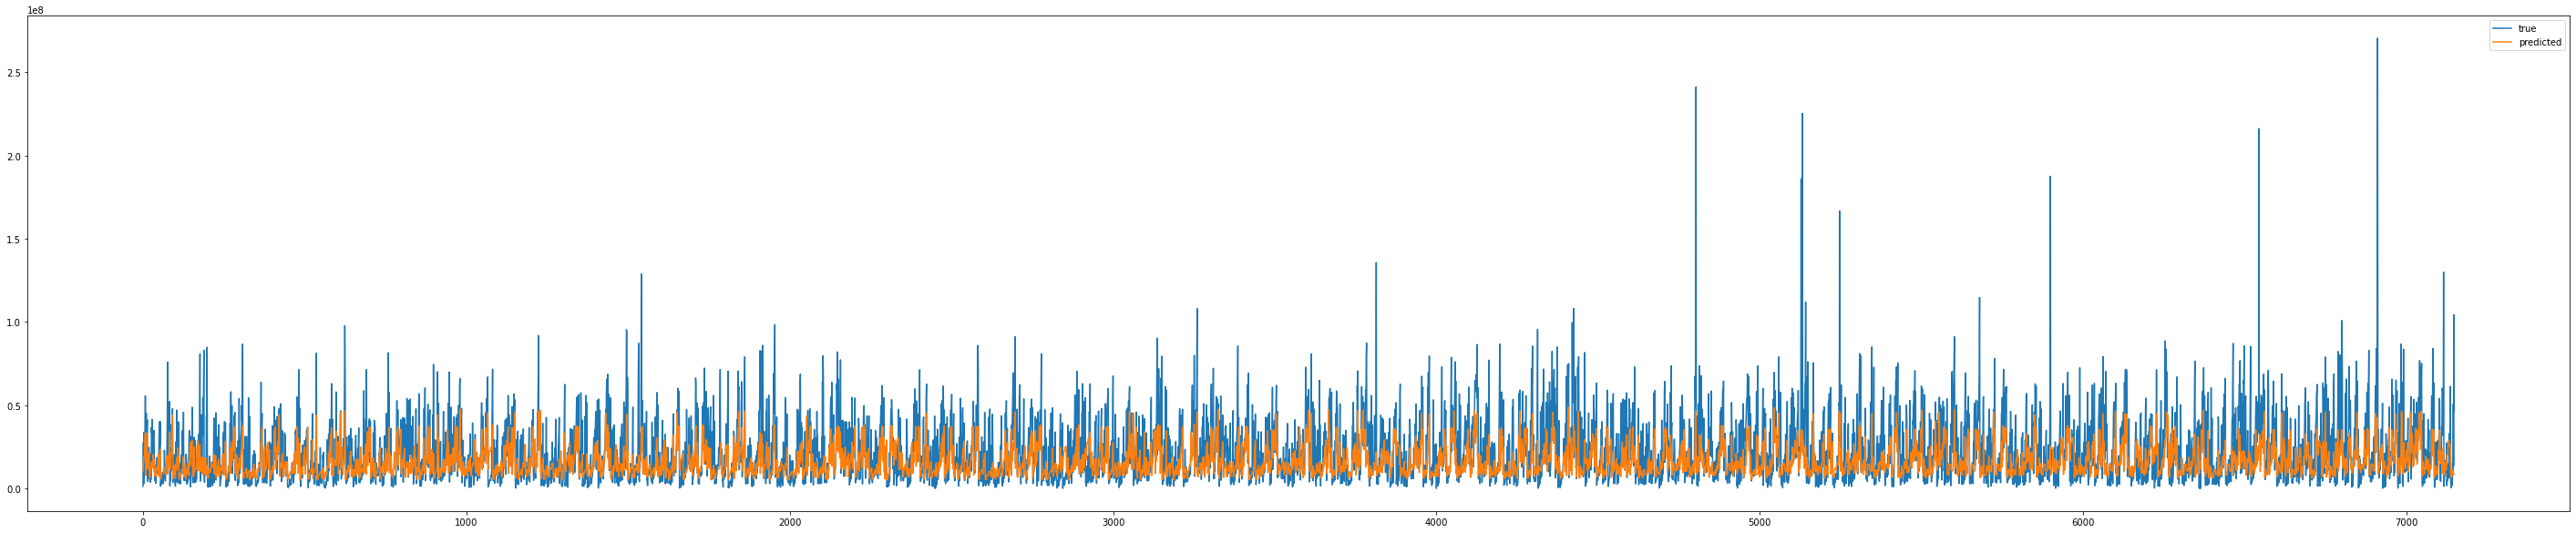

In [57]:
x = range(0,7149)
plt.figure(figsize=(50,10))
plt.plot(x,val2_y,label='true')
plt.plot(x,oof_preds2, label='predicted')

# call with no parameters
plt.legend()

plt.show()

In [56]:
neg_mape(val2_y, oof_preds2)

-88.93499404237868

In [66]:
fi = {'name' : model_mape.feature_name_,
    'importance': model_mape.feature_importances_}
fi = pd.DataFrame(fi, columns = ['name','importance'])
fi.sort_values(by=['importance'], inplace=True, ascending = False)

In [71]:
fi.iloc[:30,:]

,name,importance
9,small_c,4899
8,parttime,3184
68,ts_pred,2787
6,min_start,2383
10,middle_c,1788
7,japp,1544
42,exposed_t,1421
29,steady,1410
32,pay,1325
1,판매단가,1042


In [72]:
fi.iloc[30:,:]

,name,importance
58,mobile_middle,36
36,winter,34
49,age50_middle,27
12,primetime,21
44,age40_small,21
45,age50_small,18
2,months,18
48,age40_middle,18
22,lag_bigcat_price_day,17
53,age50_big,15


## 3.

In [ ]:
gbm1 = LGBMRegressor(objective = 'regression', 
                     boosting_type = 'dart', 
                     metric = 'mape',
                     n_estimators = 3000, #10000
                     num_leaves = 10, #10
                     learning_rate = 0.002, #0.01
                     bagging_fraction = 0.9,
                     feature_fraction = 0.5,
                     bagging_seed = 0,
                     categorical_feature = [0,9,10,11],
                     #max_depth = 10,
                                         )

model_mape = gbm1.fit(train3_x,train3_y, eval_set=[(val3_x, val3_y)],verbose = 100, 
                        eval_metric = 'mape', early_stopping_rounds = 100) ##100
oof_preds3 = gbm1.predict(val3_x, num_iteration= model_mape.best_iteration_)
    
oof_preds3[oof_preds3 < 0] = 0
x = range(0,7149)
plt.figure(figsize=(10,10))
plt.plot(x,val3_y,label='true')
plt.plot(x,oof_preds3, label='predicted')

# call with no parameters
plt.legend()

plt.show()

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[100]	valid_0's mape: 1.07056
[200]	valid_0's mape: 0.845862
[300]	valid_0's mape: 0.830842
[400]	valid_0's mape: 0.83399
[500]	valid_0's mape: 0.842065
[600]	valid_0's mape: 0.853788
[700]	valid_0's mape: 0.860213
[800]	valid_0's mape: 0.868056
[900]	valid_0's mape: 0.890345
[1000]	valid_0's mape: 0.905185
[1100]	valid_0's mape: 0.917213
[1200]	valid_0's mape: 0.923993
[1300]	valid_0's mape: 0.947357
[1400]	valid_0's mape: 0.973599
[1500]	valid_0's mape: 0.988815
[1600]	valid_0's mape: 1.01698
[1700]	valid_0's mape: 1.02608
[1800]	valid_0's mape: 1.03859
[1900]	valid_0's mape: 1.06431
[2000]	valid_0's mape: 1.07591
[2100]	valid_0's mape: 1.10345
[2200]	valid_0's mape: 1.12062
[2300]	valid_0's mape: 1.1383
[2400]	valid_0's mape: 1.16649
[2500]	valid

## 4.

In [18]:
train4_y.shape

(16904,)

[100]	valid_0's mape: 1.04058
[200]	valid_0's mape: 0.808535
[300]	valid_0's mape: 0.776648
[400]	valid_0's mape: 0.764769
[500]	valid_0's mape: 0.754853
[600]	valid_0's mape: 0.758957
[700]	valid_0's mape: 0.752141
[800]	valid_0's mape: 0.749072
[900]	valid_0's mape: 0.756992
[1000]	valid_0's mape: 0.761785
[1100]	valid_0's mape: 0.762398
[1200]	valid_0's mape: 0.761038
[1300]	valid_0's mape: 0.77291
[1400]	valid_0's mape: 0.782257
[1500]	valid_0's mape: 0.788778
[1600]	valid_0's mape: 0.80207
[1700]	valid_0's mape: 0.80121
[1800]	valid_0's mape: 0.803952
[1900]	valid_0's mape: 0.815435
[2000]	valid_0's mape: 0.818439
[2100]	valid_0's mape: 0.831431
[2200]	valid_0's mape: 0.84004
[2300]	valid_0's mape: 0.846086
[2400]	valid_0's mape: 0.861773
[2500]	valid_0's mape: 0.865771
[2600]	valid_0's mape: 0.866398
[2700]	valid_0's mape: 0.870806
[2800]	valid_0's mape: 0.870713
[2900]	valid_0's mape: 0.870629
[3000]	valid_0's mape: 0.879635


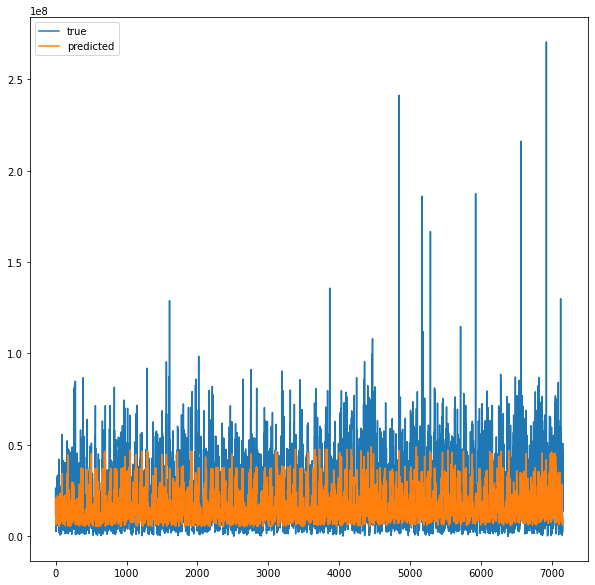

In [22]:
gbm1 = LGBMRegressor(objective = 'regression', 
                     boosting_type = 'dart', 
                     metric = 'mape',
                     n_estimators = 3000, #10000
                     num_leaves = 10, #10
                     learning_rate = 0.002, #0.01
                     bagging_fraction = 0.9,
                     feature_fraction = 0.5,
                     bagging_seed = 0,
                     categorical_feature = [0,9,10,11],
                     #max_depth = 10,
                                         )

model_mape = gbm1.fit(train4_x,train4_y, eval_set=[(val4_x, val4_y)],verbose = 100, 
                        eval_metric = 'mape', early_stopping_rounds = 100) ##100
oof_preds4 = gbm1.predict(val4_x, num_iteration= model_mape.best_iteration_)
    
oof_preds4[oof_preds4 < 0] = 0
x = range(0,7149)
plt.figure(figsize=(10,10))
plt.plot(x,val4_y,label='true')
plt.plot(x,oof_preds4, label='predicted')

# call with no parameters
plt.legend()

plt.show()

In [24]:
def neg_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    result = (-1)*mape
    return result
neg_mape(val4_y, oof_preds4)

-87.96353870440299

## 5.

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[100]	valid_0's mape: 1.0561
[200]	valid_0's mape: 0.828767
[300]	valid_0's mape: 0.808141
[400]	valid_0's mape: 0.805681
[500]	valid_0's mape: 0.807246
[600]	valid_0's mape: 0.817548
[700]	valid_0's mape: 0.8198
[800]	valid_0's mape: 0.822809
[900]	valid_0's mape: 0.839486
[1000]	valid_0's mape: 0.851135
[1100]	valid_0's mape: 0.858577
[1200]	valid_0's mape: 0.861702
[1300]	valid_0's mape: 0.881827
[1400]	valid_0's mape: 0.901795
[1500]	valid_0's mape: 0.913718
[1600]	valid_0's mape: 0.937654
[1700]	valid_0's mape: 0.944
[1800]	valid_0's mape: 0.953597
[1900]	valid_0's mape: 0.975068
[2000]	valid_0's mape: 0.98458
[2100]	valid_0's mape: 1.00858
[2200]	valid_0's mape: 1.02345
[2300]	valid_0's mape: 1.03616
[2400]	valid_0's mape: 1.05928
[2500]	valid

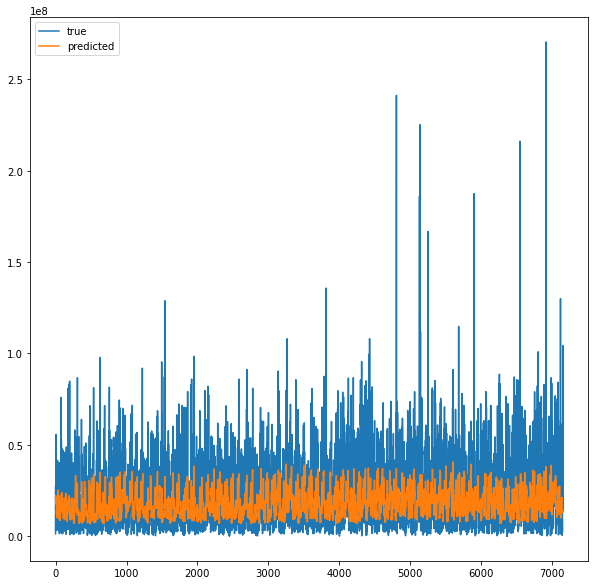

In [26]:
gbm1 = LGBMRegressor(objective = 'regression', 
                     boosting_type = 'dart', 
                     metric = 'mape',
                     n_estimators = 3000, #10000
                     num_leaves = 30, #10
                     learning_rate = 0.002, #0.01
                     bagging_fraction = 0.9,
                     feature_fraction = 0.5,
                     bagging_seed = 0,
                     categorical_feature = [0,9,10,11],
                     #max_depth = 10,
                                         )

model_mape = gbm1.fit(train5_x,train5_y, eval_set=[(val5_x, val5_y)],verbose = 100, 
                        eval_metric = 'mape', early_stopping_rounds = 100) ##100
oof_preds5 = gbm1.predict(val5_x, num_iteration= model_mape.best_iteration_)
    
oof_preds5[oof_preds5 < 0] = 0
x = range(0,7149)
plt.figure(figsize=(10,10))
plt.plot(x,val5_y,label='true')
plt.plot(x,oof_preds5, label='predicted')

# call with no parameters
plt.legend()

plt.show()

In [27]:
neg_mape(val5_y, oof_preds5)

-109.9582469980867

## 6.

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[100]	valid_0's mape: 1.0979
[200]	valid_0's mape: 0.878854
[300]	valid_0's mape: 0.874541
[400]	valid_0's mape: 0.892626
[500]	valid_0's mape: 0.916966
[600]	valid_0's mape: 0.937065
[700]	valid_0's mape: 0.958734
[800]	valid_0's mape: 0.973977
[900]	valid_0's mape: 1.0116
[1000]	valid_0's mape: 1.03783
[1100]	valid_0's mape: 1.06009
[1200]	valid_0's mape: 1.07203
[1300]	valid_0's mape: 1.10539
[1400]	valid_0's mape: 1.14377
[1500]	valid_0's mape: 1.16357
[1600]	valid_0's mape: 1.20265
[1700]	valid_0's mape: 1.22181
[1800]	valid_0's mape: 1.2395
[1900]	valid_0's mape: 1.27474
[2000]	valid_0's mape: 1.29146
[2100]	valid_0's mape: 1.32644
[2200]	valid_0's mape: 1.34964
[2300]	valid_0's mape: 1.37173
[2400]	valid_0's mape: 1.40445
[2500]	valid_0's map

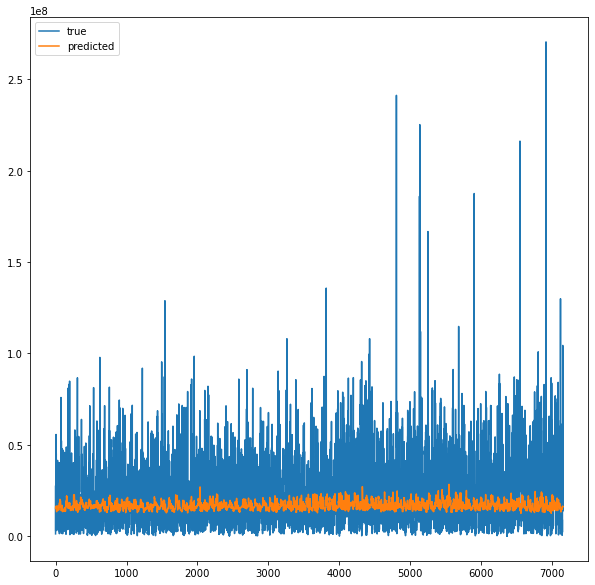

In [49]:
gbm1 = LGBMRegressor(objective = 'regression', 
                     boosting_type = 'dart', 
                     metric = 'mape',
                     n_estimators = 3000, #10000
                     num_leaves = 30, #10
                     learning_rate = 0.002, #0.01
                     bagging_fraction = 0.9,
                     feature_fraction = 0.5,
                     bagging_seed = 0,
                     categorical_feature = [0,9,10,11],
                     #max_depth = 10,
                                         )

model_mape = gbm1.fit(train6_x,train6_y, eval_set=[(val6_x, val6_y)],verbose = 100, 
                        eval_metric = 'mape', early_stopping_rounds = 100) ##100
oof_preds6 = gbm1.predict(val6_x, num_iteration= model_mape.best_iteration_)
    
oof_preds6[oof_preds6 < 0] = 0
x = range(0,7149)
plt.figure(figsize=(10,10))
plt.plot(x,val6_y,label='true')
plt.plot(x,oof_preds6, label='predicted')

# call with no parameters
plt.legend()

plt.show()

## 6.

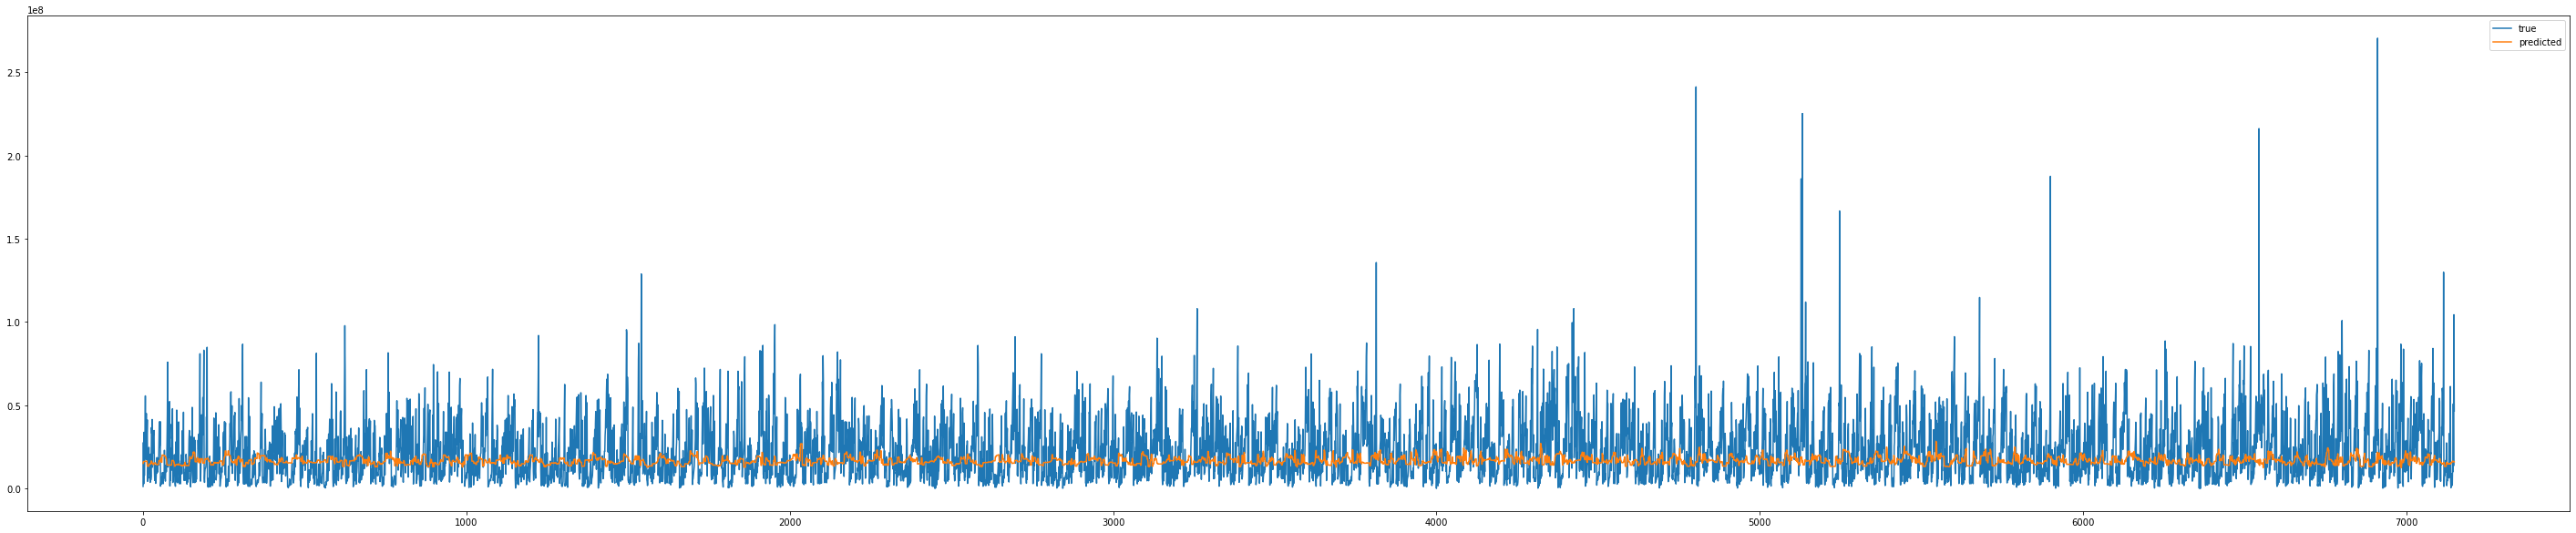

In [50]:
x = range(0,7149)
plt.figure(figsize=(50,10))
plt.plot(x,val6_y,label='true')
plt.plot(x,oof_preds6, label='predicted')

# call with no parameters
plt.legend()

plt.show()

## 7. 

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[100]	valid_0's mape: 1.03847
[200]	valid_0's mape: 0.804038
[300]	valid_0's mape: 0.773518
[400]	valid_0's mape: 0.759909
[500]	valid_0's mape: 0.752212
[600]	valid_0's mape: 0.755496
[700]	valid_0's mape: 0.749523
[800]	valid_0's mape: 0.748922
[900]	valid_0's mape: 0.757509
[1000]	valid_0's mape: 0.761909
[1100]	valid_0's mape: 0.763387
[1200]	valid_0's mape: 0.763422
[1300]	valid_0's mape: 0.776427
[1400]	valid_0's mape: 0.78856
[1500]	valid_0's mape: 0.795464
[1600]	valid_0's mape: 0.81209
[1700]	valid_0's mape: 0.810907
[1800]	valid_0's mape: 0.813948
[1900]	valid_0's mape: 0.829536
[2000]	valid_0's mape: 0.834572
[2100]	valid_0's mape: 0.849628
[2200]	valid_0's mape: 0.858773
[2300]	valid_0's mape: 0.865291
[2400]	valid_0's mape: 0.880132
[25

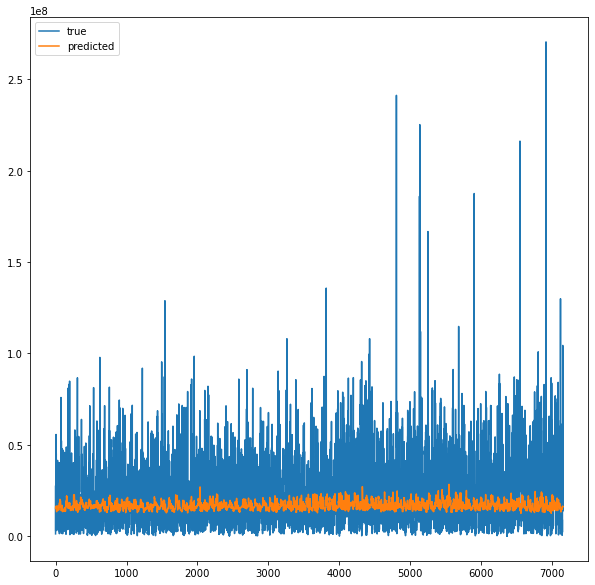

In [76]:
gbm1 = LGBMRegressor(objective = 'regression', 
                     boosting_type = 'dart', 
                     metric = 'mape',
                     n_estimators = 3000, #10000
                     num_leaves = 30, #10
                     learning_rate = 0.002, #0.01
                     bagging_fraction = 0.9,
                     feature_fraction = 0.5,
                     bagging_seed = 0,
                     categorical_feature = [0,9,10,11],
                     #max_depth = 10,
                                         )

model_mape = gbm1.fit(train7_x,train7_y, eval_set=[(val7_x, val7_y)],verbose = 100, 
                        eval_metric = 'mape', early_stopping_rounds = 100) ##100
oof_preds7 = gbm1.predict(val7_x, num_iteration= model_mape.best_iteration_)
    
oof_preds7[oof_preds7 < 0] = 0
x = range(0,7149)
plt.figure(figsize=(10,10))
plt.plot(x,val7_y,label='true')
plt.plot(x,oof_preds6, label='predicted')

# call with no parameters
plt.legend()

plt.show()

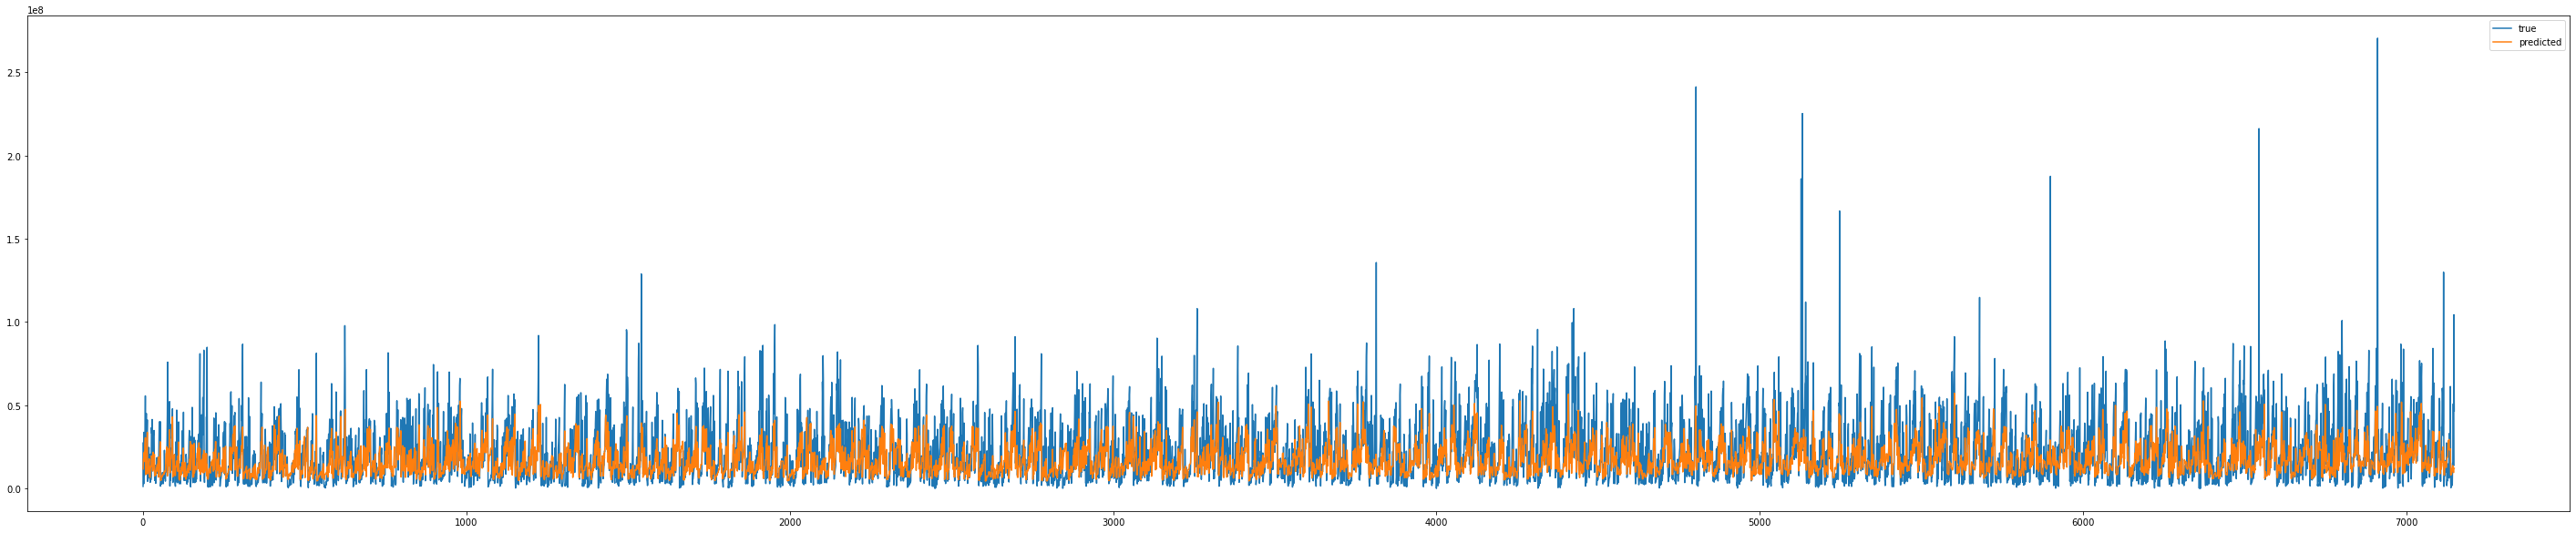

In [94]:
oof_preds7 = gbm1.predict(val7_x, num_iteration= 3000)
    
oof_preds7[oof_preds7 < 0] = 0
x = range(0,7149)
plt.figure(figsize=(50,10))
plt.plot(x,val7_y,label='true')
plt.plot(x,oof_preds7, label='predicted')

# call with no parameters
plt.legend()

plt.show()

In [93]:
model_mape.best_score_

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('mape', 0.896265138676175)])})

In [80]:
fi = {'name' : model_mape.feature_name_,
    'importance': model_mape.feature_importances_}
fi = pd.DataFrame(fi, columns = ['name','importance'])
fi.sort_values(by=['importance'], inplace=True, ascending = False)

In [95]:
neg_mape(val7_y, oof_preds7)

-89.62651386721731

In [82]:
fi.iloc[:30,:]

,name,importance
67,ts_pred,6844
1,판매단가,6638
9,middle_c,6268
6,min_start,5112
8,parttime,4427
17,lag_mcode_price,4377
41,exposed_t,4245
7,japp,4150
13,freq,3476
31,pay,3396


In [83]:
fi.iloc[30:,:]

,name,importance
44,age50_small,720
27,bpower,702
2,months,679
49,age60above_middle,575
45,age60above_small,527
21,lag_bigcat_price_day,520
42,age30_small,502
52,age50_big,462
65,lag_sales_wd_4,455
57,mobile_middle,437


In [ ]:
import 

In [129]:
lgb_params = {      'boosting_type': 'dart',# Standart boosting type
                    'objective': 'regression',       # Standart loss for RMSE
                    'metric': 'mape',              # as we will use rmse as metric "proxy"
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'num_leaves': 2**5-1,            # We will need model only for fast check
                    'min_data_in_leaf': 200,      # So we want it to train faster even with drop in generalization
                    'feature_fraction': 0.8,
                    'n_estimators': 1200,# We don't want to limit training (you can change 5000 to any big enough number
                    'num_iterations': 5000,
                    'learning_rate' : 0.001,
                    'categorical_feature':[0,9,10,11]
                    #'scale_pos_weight' : 1.3,
                    #'categorical_feature': [0,1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26],
                }
lgb_train = lgb.Dataset(train7_x,train7_y)
lgb_valid = lgb.Dataset(val7_x,val7_y)

gbm = lgb.train(lgb_params, lgb_train,1200,valid_sets=[lgb_train, lgb_valid],early_stopping_rounds=20, verbose_eval=100)
oof_preds8 = gbm.predict(val7_x, num_iteration=gbm.best_iteration)
importance_df = pd.DataFrame()
importance_df['importance'] = gbm.feature_importance()
importance_df['names'] = gbm.feature_name_()

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9569
[LightGBM] [Info] Number of data points in the train set: 16904, number of used features: 67
[LightGBM] [Info] Start training from score 21226375.354946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

AttributeError: 'Booster' object has no attribute 'feature_name_'

In [131]:
oof_preds8 = gbm.predict(val7_x, num_iteration=gbm.best_iteration)
importance_df = pd.DataFrame()
importance_df['importance'] = gbm.feature_importance()
importance_df['names'] = gbm.feature_name()

In [132]:
importance_df

,importance,names
0,782,상품군
1,4533,판매단가
2,77,months
3,1,weekdays
4,9,hours_inweek
...,...,...
63,651,lag_sales_wd_2
64,359,lag_sales_wd_3
65,111,lag_sales_wd_4
66,725,lag_sales_wd_5


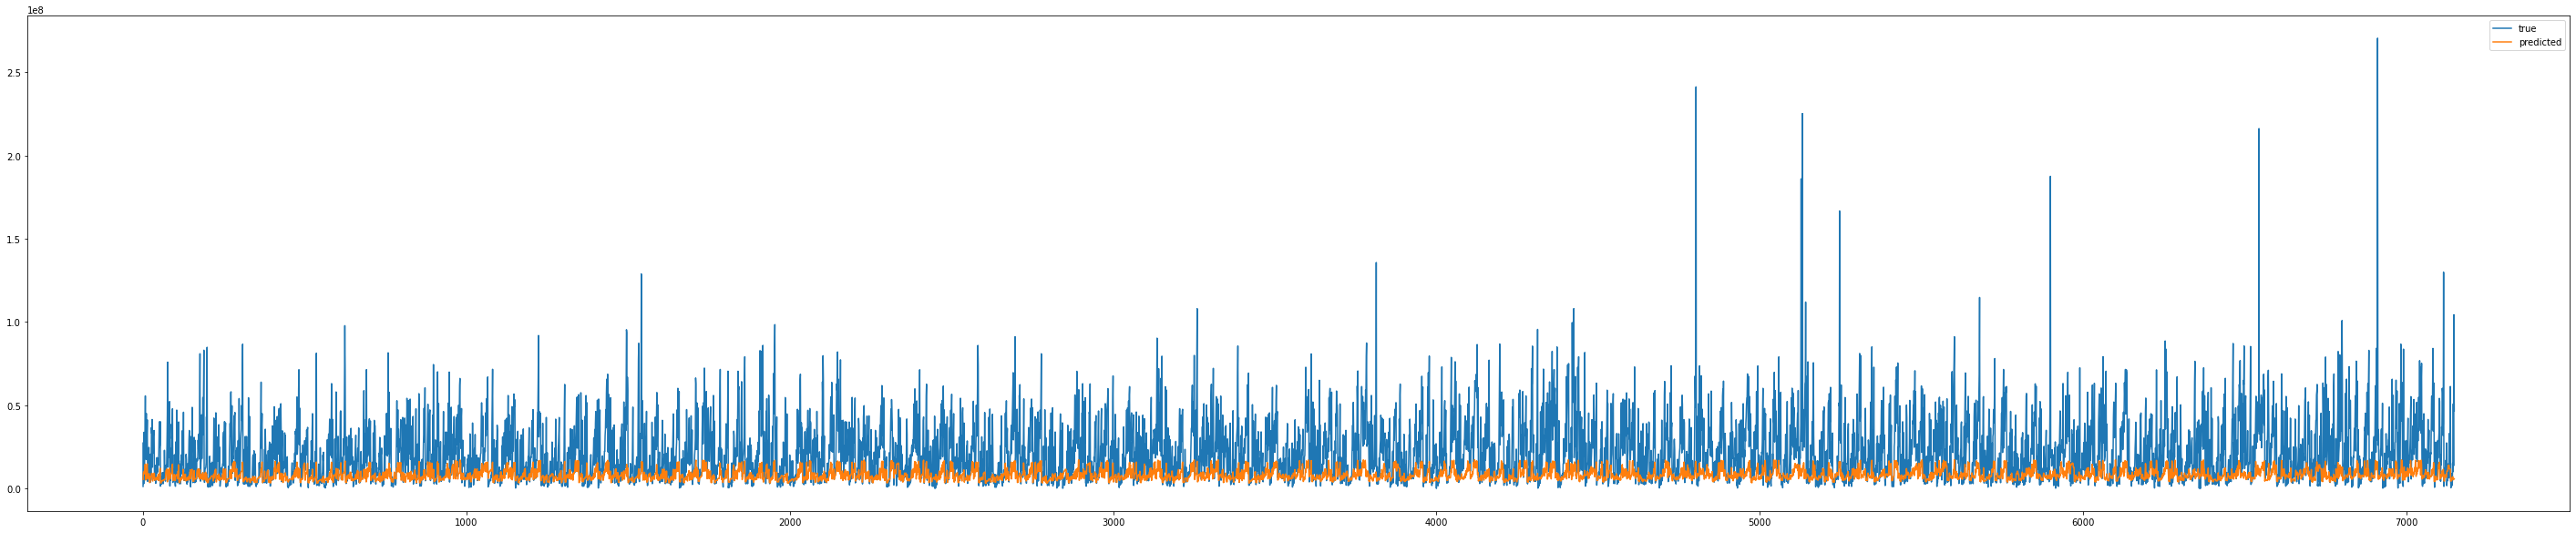

In [133]:
oof_preds8[oof_preds8 < 0] = 0
x = range(0,7149)
plt.figure(figsize=(50,10))
plt.plot(x,val7_y,label='true')
plt.plot(x,oof_preds8, label='predicted')

# call with no parameters
plt.legend()

plt.show()

In [134]:
neg_mape(val7_y, oof_preds8)

-71.79197807337616

In [137]:
np.mean(oof_preds8-val7_y)

-14239973.762474641

In [138]:
np.mean(oof_preds7-val7_y)

-5270382.02601515

In [139]:
val7_y

16904      1388000.0
16905     27751000.0
16906      2981000.0
16907     33857000.0
16908      7894000.0
            ...     
24048     10157000.0
24049     50929000.0
24050     13765000.0
24051    104392000.0
24052     46608000.0
Name: 취급액, Length: 7149, dtype: float64

In [140]:
oof_preds7

array([11864627.064296  , 17954973.50690215, 17413341.20555636, ...,
        9710562.39887633, 12077283.42971059, 12283135.84639885])

In [141]:
oof_preds8

array([5578453.82402502, 9635895.61951357, 9421074.96501786, ...,
       5436635.55566968, 5895610.02084101, 5977084.19356696])